In [1]:
# import libraries

import numpy as np
import pandas as pd
import os
from tqdm import tqdm


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from scipy.integrate import odeint, solve_ivp
from scipy.fft import fft


import matplotlib.pylab as plt
import seaborn as sns
import mpl_interactions.ipyplot as iplt
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)

# Machine Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import Sequence
from tensorflow import keras

import shap as shap
try:
    import lime
    import lime.lime_tabular    
except ImportError:
    pass

# Enable Jupyter Notebook's intellisense
%config IPCompleter.greedy=True
%matplotlib inline

%matplotlib notebook
from ipywidgets import *
import matplotlib
import matplotlib.pyplot as plt

# for reproducibility of this notebook:
rng = np.random.RandomState(42)
#tf.random.set_seed(42)
np.random.seed(42)

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

#matplotlib.use('TkAgg')


In [2]:
class Duffing():
    """
        Class for the Duffing Oscillator
    """
    def __init__(self, parameters = {'alpha': 0.3, 'beta': -0.1, 'gamma': 0.37, 'delta': 0.3, 'omega': 1.2}, labels = ['xt','vt'], features = ['x0','v0','t','rand'], scaler = None):
        """
            Define Parameter Configuration to Model

            Parameters
            ----------
            alpha : float, linear stiffness
            beta  : float, non linearity in the restoring force
            gamma : float, amplitude of the periodic driving force
            delta : float, amount of damping
            omega : float, angular frequency of the periodic driving force
        """   
        self.parameters = parameters
        self.labels = labels
        self.features = features
        self.scaler = scaler
        self.suffix = "params_"+str(parameters['alpha'])+"_"+str(parameters['beta'])+"_"+str(parameters['gamma'])+"_"+str(parameters['delta'])+"_"+str(parameters['omega'])

    def eom(self, t, u):
        """
            Duffing Oscillator Equation of Motion

            ddx + delta * dx + alpha * x + beta * x**3 = gamma * cos(omega * t)

            Input
            ----------
            u : vector of length 2, (x,v)
                Position and Velocity at time t
            t : float, the time t

            Returns
            ----------
            [dx,ddx] : Tuple, Time derivatives of 
                        position and velocity at time t
        """
        x, dx = u[0], u[1]
        ddx = (self.parameters['gamma'] * np.cos(self.parameters['omega'] * t) - (self.parameters['delta'] * dx + self.parameters['alpha'] * x + self.parameters['beta'] * x**3))

        return [dx,ddx]

    def termination_event(self, t, y):
        """
            Stops Numerical Integration once points wander too far away
        """
        return (np.abs(y[0]) - 10)*(np.abs(y[1]) - 10)
    termination_event.terminal = True


    def generate(self, num_samples = int(5e1), samples=10, end_time=100, gridded=False):
        """
            Generates training samples using scipy.integrate.odeint
            to calculate the temporal evolution of a Duffing system.
    
            Samples randomly from x0 in [-2,2], v0 in [-1,1].
    
            For each set of initial conditions we generate a trajectory.
            The trajectory is randomly sampled to generate training
            pairs: X = (x0,v0,t), y = (xt,vt)
    
            Input
            ----------
            num_samples : int, number of training
                            samples to be generated
    
            Returns
            ----------
            X : array((num_samples,3)), each entry in the array
                is a training sample (x0,v0,t)
            y : array((num_samples,2)), each entry in the array
                is a target sample (xt,vt)
        """
            
        #Define bounds of the sampling
        x_min = -2
        x_max = 2
        v_min = -2
        v_max = 2
        #Initialise the output arrays        
        X = np.empty((num_samples*(samples), len(np.hstack((self.features, self.labels)))))
        #Define the t_range to draw from
        t_range = np.linspace(0, end_time, 100, endpoint=False)
        t_vals = np.sort(np.random.choice(t_range, size = samples, replace=False))
        if gridded:
            x_range = np.linspace(x_min, x_max, int(np.sqrt(num_samples)), endpoint = True)
            v_range = np.linspace(v_min, v_max, int(np.sqrt(num_samples)), endpoint = True)
            #Generate num_samples samples
            for i, x0 in tqdm(enumerate(x_range), desc="Generating Data…", ascii=False, ncols=75):
                for v0 in v_range:
                    #Generate a trajectory
                    trajectory = solve_ivp(self.eom, [0, end_time], [x0,v0], t_eval = t_vals, events = [self.termination_event])
                    traj_cutoff =  samples - len(trajectory.y[0])
                    if traj_cutoff > 0:
                        trajectory.y[0] = np.append(trajectory.y[0].reshape(-1,1), 10.0*np.ones(traj_cutoff))
                        trajectory.y[1] = np.append(trajectory.y[1].reshape(-1,1), 10.0*np.ones(traj_cutoff))
                    X[i*samples:(i+1)*samples,:] = np.hstack((x0*np.ones(samples).reshape(-1,1), 
                                                        v0*np.ones(samples).reshape(-1,1), 
                                                        t_vals.reshape(-1,1), 
                                                        np.random.uniform(-1,1,samples).reshape(-1,1),
                                                        trajectory.y[0].reshape(-1,1), 
                                                        trajectory.y[1].reshape(-1,1)))

        else:
            #Generate num_samples samples
            for i in tqdm(range(num_samples), desc="Generating Data…", ascii=False, ncols=75):
                #Generate random starting positions
                x0 = (x_max - x_min) * np.random.random_sample() + x_min
                v0 = (v_max - v_min) * np.random.random_sample() + v_min 
                #Generate a trajectory
                trajectory = solve_ivp(self.eom, [0, end_time], [x0,v0], t_eval = t_vals, events = [self.termination_event])
                traj_cutoff =  samples - len(trajectory.y[0])
                if traj_cutoff > 0:
                    x_traj = np.vstack((trajectory.y[0].reshape(-1,1), 10.0*np.ones(traj_cutoff).reshape(-1,1)))
                    v_traj = np.vstack((trajectory.y[1].reshape(-1,1), 10.0*np.ones(traj_cutoff).reshape(-1,1)))
                    X[i*samples:(i+1)*samples,:] = np.hstack((x0*np.ones(samples).reshape(-1,1), 
                                                            v0*np.ones(samples).reshape(-1,1), 
                                                            t_vals.reshape(-1,1), 
                                                            np.random.uniform(-1,1,samples).reshape(-1,1),
                                                            x_traj, 
                                                            v_traj))
                else:
                    X[i*samples:(i+1)*samples,:] = np.hstack((x0*np.ones(samples).reshape(-1,1), 
                                                            v0*np.ones(samples).reshape(-1,1), 
                                                            t_vals.reshape(-1,1), 
                                                            np.random.uniform(-1,1,samples).reshape(-1,1),
                                                            trajectory.y[0].reshape(-1,1), 
                                                            trajectory.y[1].reshape(-1,1)))
        
        self.X_df = pd.DataFrame(X, columns = np.hstack((self.features, self.labels)))
        return self.X_df

    def scale_features(self):
        if self.scaler == None:
            self.scaler = MinMaxScaler(feature_range=[0,1])
            self.X_df[self.features] = self.scaler.fit_transform(self.X_df[self.features].values)
        else: return



    def predict(self, X):
        if self.scaler == None:
            self.scale_features()
        else:
            if type(X) == pd.core.frame.DataFrame:
                X_temp = pd.DataFrame(self.scaler.inverse_transform(X.values), columns=X.columns)
            elif type(X) == np.ndarray:
                X_temp = pd.DataFrame(self.scaler.inverse_transform(X), columns=self.features)
        
        y = np.ones((np.shape(X_temp)[0], 2))
        for i in range(0,np.shape(X_temp)[0]):
            traj = solve_ivp(self.eom, [0, X_temp['t'].iloc[i]], [X_temp['x0'].iloc[i], X_temp['v0'].iloc[i]], 
                            t_eval = None, events = [self.termination_event])
            y[i] = [traj.y[0][-1], traj.y[1][-1]]
        return y

    def predict_x(self, X):
        if self.scaler == None:
            self.scale_features()
        else:
            if type(X) == pd.core.frame.DataFrame:
                X_temp = pd.DataFrame(self.scaler.inverse_transform(X.values), columns=X.columns)
            elif type(X) == np.ndarray:
                X_temp = pd.DataFrame(self.scaler.inverse_transform(X), columns=self.features)   
        y = np.ones((np.shape(X_temp)[0], 1))
        for i in range(0,np.shape(X_temp)[0]):
            traj = solve_ivp(self.eom, [0, X_temp['t'].iloc[i]], [X_temp['x0'].iloc[i], X_temp['v0'].iloc[i]], t_eval = None, events = [self.termination_event])
            y[i] = traj.y[0][-1]   
        return y

    def predict_v(self, X):
        if self.scaler == None:
            self.scale_features()
        else:
            if type(X) == pd.core.frame.DataFrame:
                X_temp = pd.DataFrame(self.scaler.inverse_transform(X.values), columns=X.columns)
            elif type(X) == np.ndarray:
                X_temp = pd.DataFrame(self.scaler.inverse_transform(X), columns=self.features)   
        
        y = np.ones((np.shape(X_temp)[0], 1))
        for i in range(0,np.shape(X_temp)[0]):
            traj = solve_ivp(self.eom, [0, X_temp['t'].iloc[i]], [X_temp['x0'].iloc[i], X_temp['v0'].iloc[i]], t_eval = None, events = [self.termination_event])
            y[i] = traj.y[1][-1]
            
        return y

        
    def vals_to_df(self, values, data, save=False, explainer = "lime", suffix = None):
        xt_atts = values[0]
        vt_atts = values[1]
        data = data
        
        param_array = np.array(np.ones((data.shape[0], 5)))
        for i, param in enumerate(self.parameters):
            param_array[:,i] = self.parameters[param]*np.ones((data.shape[0]))

        df = pd.DataFrame(xt_atts, columns = [self.labels[0] + "_" + i for i in self.features])
        df = df.join(pd.DataFrame(vt_atts, columns = [self.labels[1] + "_" + i for i in self.features]))
        df = df.join(pd.DataFrame(data.values, columns = self.features))
        df = df.join(pd.DataFrame(param_array, columns = self.parameters.keys()))
        df.insert(df.shape[1], 'explainer' ,[explainer for _ in range(df.shape[0])])
        if save:
            df.to_csv("Results/"+explainer+"/"+explainer+"_vals_"+suffix+".csv")
        return df


In [3]:
class NumericExplainer():
    """
        Pretty Brute force numerical gradient calculation for
        explainability of a known function
    """
    def __init__(self, f, features, labels,  h=0.01):
        """
            Initialises with some configurations for the gradient calculation
            as well as the function being differentiated.
            
            Inputs
            --------
            f : function that takes a pandas.DataFrame and outputs a 2d np.array.
            features : list of features in the pd.DataFrame for which we are to 
                differentiate f.
            labels : list of features in the np.array.
        """
        self.f = f
        self.features = features
        self.labels = labels
        self.h = h
        
    def gradient(self, X_val, feature):
        """
            Numerical Gradient Calculation by way of a CFD method.
            Inputs
            --------
            X_val : pandas.DataFrame with columns: features and values at
                which we want to take the numerical gradient.
            feature : feature by which we want to differentiate.
        """
        X_prime_plus = X_val.copy()
        X_prime_plus.loc[:,(feature)] = X_prime_plus[feature] + self.h
        X_prime_minus = X_val.copy()
        X_prime_minus.loc[:,(feature)] = X_prime_minus[feature] - self.h
        
        grad = (self.f(X_prime_plus) - self.f(X_prime_minus))/(2*self.h)
        
        return grad
    def feature_att(self, X):
        """
            Calculates the Gradients for all Entries in X, for each
            feature and label combination.
            
            Inputs
            --------
            X : pandas.DataFrame with columns:features and values at
                which we want to differentiate.
            Returns
            --------
            self.__atts : [np.array[...],np.array[...]] of gradients at
                each of the input points. Calculated for each label and stacked.
        """
        first_run = True
        for i,__label in enumerate(self.labels):
            grads = self.gradient(X, self.features[0])[:,i]
            for __feat in self.features[1:]:
                grads = np.vstack((grads,self.gradient(X, __feat)[:,i]))
            normalised_grads = np.abs(grads)/np.sum(np.abs(grads),axis=0)
            if first_run:
                self.__atts = grads.transpose()
                self.__normalised = normalised_grads.transpose()
                first_run = False
            else:
                self.__atts = [self.__atts, grads.transpose()]
                self.__normalised = [self.__normalised, normalised_grads.transpose()]
                        
        return self.__atts#, self.__normalised

In [23]:
class Bootstrapper():
    def __init__(self, model, data, features, labels, suffix, explainer_type, num_straps = 50, back_size = 100):
        self.explainer_type = explainer_type
        self.model = model
        self.data = data
        self.features = features
        self.labels = labels
        self.num_straps = num_straps
        self.back_size = back_size
        self.suffix = suffix
        
    def bootstrap(self, X):
        self.values = np.empty((self.num_straps, len(self.labels), len(self.features)))
        self.mean_std_arr = np.empty((2, len(self.labels), len(self.features)))
        for i in range(self.num_straps):
            background_i = shap.sample(self.data, self.back_size, random_state = np.random.randint(100))
            if self.explainer_type == 'kernel':
                exp_i = shap.KernelExplainer(self.model, background_i)
                shapper = exp_i.shap_values(X)
            elif self.explainer_type == 'sample':
                exp_i = shap.SampleExplainer(self.model, background_i)
                shapper = exp_i.shap_values(X)
            elif self.explainer_type == 'lime':
                exp_i = MyLime(self.model, background_i, mode="regression")
                shapper = exp_i.attributions(X)
            self.values[i,0,:] = shapper[0]
            self.values[i,1,:] = shapper[1]
        for i in range(len(self.labels)):
            for j in range(len(self.features)):
                self.mean_std_arr[0, i, j] = np.mean(self.values[:,i,j])
                self.mean_std_arr[1, i, j] = np.std(self.values[:,i,j])
            
        return self.mean_std_arr
    
    def to_df(self):
        self.bootstrap_df = self.x_list.copy()
        for k, col in enumerate(["mean", "std"]):
            for j in range(len(self.labels)):
                for i in range(len(self.features)):
                    self.bootstrap_df.insert(4 + i + j*len(self.features) + k*len(self.features)*len(self.labels), 
                                             self.features[i] + "_" + self.labels[j] + "_" + col, 
                                             self.bootstrap_array[:,k,j,i])
        if self.save:
            self.bootstrap_df.to_csv("Results/"+self.explainer_type+"/"+self.explainer_type+"bootstrap_vals_"+self.suffix+".csv")
        return self.bootstrap_df
    def calculate(self, num_samples = 10, save = True):
        self.x_list = self.data.iloc[np.sort(np.random.choice(self.data.shape[0], num_samples, replace =False))]
        self.bootstrap_array = np.empty((num_samples, 2, len(self.labels), len(self.features)))
        for i in tqdm(range(self.x_list.shape[0]), desc="Bootstrapping…", ascii=False, ncols=75):
            x_val = self.x_list.iloc[i,:]
            self.bootstrap_array[i,:,:,:] = self.bootstrap(x_val)
        return self.to_df()

In [5]:
class MyLime(shap.other.LimeTabular):
    def __init__(self, model, data, mode="classification"):
        self.model = model
        assert mode in ["classification", "regression"]
        self.mode = mode

        if str(type(data)).endswith("pandas.core.frame.DataFrame'>"):
            data = data.values
        self.data = data
        self.explainer = lime.lime_tabular.LimeTabularExplainer(data, mode=mode)
        self.out_dim = 1#self.model(data[0:1]).shape[1]
            
    def attributions(self, X, num_samples=500, num_features=None):
        try:
            num_features = X.shape[1] if num_features is None else num_features
        except:
            num_features = 1
        
        if str(type(X)).endswith("pandas.core.frame.DataFrame'>"):
            X = X.values
            
        out = [np.zeros(X.shape) for j in range(len(self.model))]
        for i in tqdm(range(X.shape[0]), desc="Calculating Lime…", ascii=False, ncols=75):
            exp1 = self.explainer.explain_instance(X[i], self.model[0], labels=range(self.out_dim), 
                                                    num_features=num_features, num_samples=num_samples)
            exp2 = self.explainer.explain_instance(X[i], self.model[1], labels=range(self.out_dim), 
                                                    num_features=num_features, num_samples=num_samples)
            for k, v in exp1.local_exp[1]: 
                out[0][i,k] = v
            for k, v in exp2.local_exp[1]: 
                out[1][i,k] = v
          
        return out

<IPython.core.display.Javascript object>


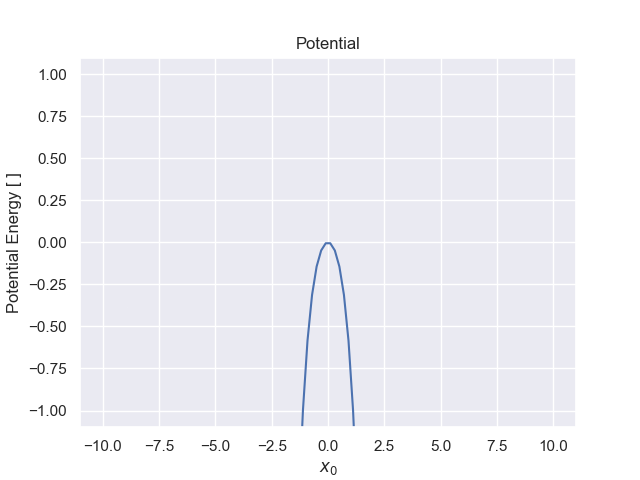

interactive(children=(FloatSlider(value=1.0, description='alpha', max=3.0, min=-1.0), FloatSlider(value=1.0, d…

In [24]:
x = np.linspace(-10,10,100)
v = 0
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(x, np.sin(x))

def update(alpha = 1.0, beta = 1.0):
    line.set_ydata(0.5*v**2 + 0.5*alpha*x**2 +0.25*beta*x**4)
    fig.canvas.draw_idle()

ax.set_title(r"Potential")
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"Potential Energy [ ]")
interact(update);

In [26]:
"""
Define Parameter Configuration to Model

    Parameters
    ----------
    alpha : float, linear stiffness
    beta  : float, non linearity in the restoring force
    gamma : float, amplitude of the periodic driving force
    delta : float, amount of damping
    omega : float, angular frequency of the periodic driving force
"""   
alpha = -1.0
beta = 1.0
gamma = 0.37
delta = 1.0
omega = 1.2

parameters_now = {'alpha': alpha, 'beta': beta, 'gamma': gamma, 'delta': delta, 'omega':omega}
duffing = Duffing(parameters = parameters_now)
eom = duffing.eom
suffix = duffing.suffix

In [27]:
end_time = 100
duffing.generate(1000, samples = 100, end_time = end_time)
duffing.scale_features()
X = duffing.X_df[duffing.features]
y = duffing.X_df[duffing.labels]

Generating Data…: 100%|████████████████| 1000/1000 [00:31<00:00, 31.71it/s]


In [29]:
model = tf.keras.models.load_model("Models/ml_model_"+suffix)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 200)               1000      
_________________________________________________________________
dense_14 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_15 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_16 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_17 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_18 (Dense)             (None, 200)              

In [15]:
def ml_x(X):
    return model.predict(X)[0]
def ml_v(X):
    return model.predict(X)[1]

In [16]:
explainers = ["kernel", "sampling", "lime", "numeric"]
true_lime = [duffing.predict_x, duffing.predict_v]
ml_lime = [ml_x, ml_v]
models = {"true" : duffing.predict, "ml" : model.predict}
lime_models = {"true" : true_lime, "ml" : ml_lime}

In [17]:
background = shap.sample(X_test, 100)
choice = X.iloc[np.sort(np.random.choice(X_test.shape[0], 100, replace =False))]

In [21]:
choice.iloc[:10,:]

,x0,v0,t,rand
188,0.940595,0.397577,0.888889,0.848670
1297,0.951623,0.124183,0.979798,0.449433
6965,0.105024,0.688450,0.656566,0.397772
12225,0.872473,0.633344,0.252525,0.415143
14097,0.055559,0.801052,0.979798,0.171058
26727,0.664866,0.460198,0.272727,0.859051
27639,0.010301,0.162010,0.393939,0.317389
28576,0.203937,0.960769,0.767677,0.767626
32275,0.174854,0.534770,0.757576,0.887651
41579,0.570255,0.874569,0.797980,0.032023


In [22]:
big_df = pd.DataFrame()
for model in models:
    for explainer in explainers:
        print(explainer + model)
        if explainer == "kernel":
            temp_explainer = shap.KernelExplainer(models[model], background)
            temp_vals = temp_explainer.shap_values(choice)
            bootstrapper = Bootstrapper(models[model], X, duffing.features, duffing.labels, suffix, explainer)
            bootstrapper.calculate(save=True)
        elif explainer == "sampling":
            temp_explainer = shap.SamplingExplainer(models[model], background)
            temp_vals = temp_explainer.shap_values(choice)
            bootstrapper = Bootstrapper(models[model], X, duffing.features, duffing.labels, suffix, explainer)
            bootstrapper.calculate(save=True)
        elif explainer == "lime":
            temp_explainer = MyLime(lime_models[model], choice, mode='regression')
            temp_vals = temp_explainer.attributions(choice)
            bootstrapper = Bootstrapper(lime_models[model], X, duffing.features, duffing.labels, suffix, explainer)
            bootstrapper.calculate(save=True)
        elif explainer == "numeric":
            temp_explainer = NumericExplainer(models[model], duffing.features, duffing.labels, h = 0.001)
            temp_vals = temp_explainer.feature_att(choice)
            bootstrapper = Bootstrapper(models[model], X, duffing.features, duffing.labels, suffix, explainer)
            bootstrapper.calculate(save=True)
        else:
            print("not a valid explainer type")
        big_df = big_df.append(duffing.vals_to_df(temp_vals, 
                                                        choice, save=False, explainer = explainer, suffix = suffix+model))
        

kerneltrue


  0%|          | 0/100 [00:00<?, ?it/s]

ValueError: Cannot take a larger sample than population when 'replace=False'